In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy import sparse
import math
import random

from tools import kaczmarz_method, myphantom, soft_skrinkage, Bregman_distance_dual, objective, dual_objective

plt.rcParams.update({
    "text.usetex": True
})

In [ ]:
# generate the radon matrix in a quite stupid way by applying it to the standard basis…
N = 50
numAngles = 60
angles = np.linspace(0,180,numAngles,endpoint=False)

# calc one sinogram to be sure that dimensions are ok
x = np.zeros((N,N))
sinogram = radon(x, theta=angles, circle=True)

M = np.prod(sinogram.shape)
radon_matrix = np.zeros((M,N**2))

for j in range(N**2):
    x = np.zeros(N**2)
    x[j] = 1
    x = np.reshape(x,(N,N),order='F')

    # Compute the Radon transform
    sinogram = radon(x, theta=angles, circle=True)
    radon_matrix[:,j] = np.reshape(sinogram,(M),order='F')
    # order='F' is column-major reshaping
    # use this also for reshaping sinograms when visualizing!

/usr/local/lib/python3.10/dist-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


(3000, 2500)


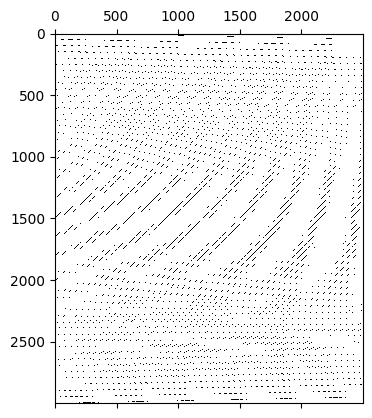

In [ ]:
plt.spy(radon_matrix)
print(radon_matrix.shape)

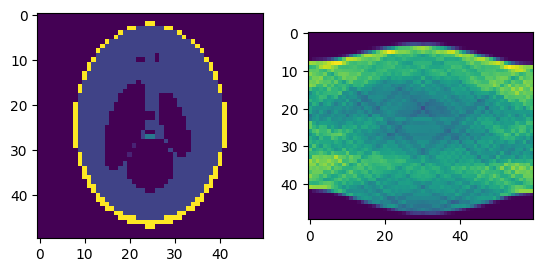

In [ ]:
# generate some sparse phantom
xhat = myphantom(N)
xhat[np.abs(xhat-0.3)<0.01] = 0
b = radon_matrix@xhat


fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.imshow(np.reshape(xhat,(N,N),order='F'))
ax2.imshow(np.reshape(b,(N,numAngles),order='F'))
plt.show()


In [ ]:
# Set data and parameters
A = radon_matrix
m, n = A.shape
x_start = np.zeros((n, 1))
x_true = xhat


# 20 epochs
max_iter = 20*m

# each projection is one block:
nber_block = numAngles

# total noise level such that we get 10% noise
sigma = 0.1*np.linalg.norm(b) # 10% noise
sigma_list = [sigma/(np.sqrt(nber_block)) for _ in range(nber_block)] # given sum(sigma_list^2) = sigma^2
# some guess for gamma
gamma_rsk = 0.001
# large lambda to promote sparsity
lambda_rsk = 30
# for comparison we also run standard Kaczmarz, i.e. lambda=0
lambda_rk = 0

# Fix the block partition
index_list = list([i for i in range(m)])
copy_index_list = index_list.copy()
Partition_lists = np.array_split(copy_index_list, nber_block)

In [ ]:
# run adaptive sparse Kaczmarz with guess for gamma and exact beta
x_arsk, residuals_arsk, errors_arsk, lr_values_arsk, beta_values_arsk = kaczmarz_method(A, x_start, b, x_true, max_iter, sigma_list, gamma_rsk,
                                                       lbda=lambda_rsk, nber_block=nber_block, p_list=Partition_lists, lr = 'oss')

# run sparse Kaczmarz with constant stepsize. Does not need gamma or beta!
x_rsk, residuals_rsk, errors_rsk, lr_values_rsk, beta_values_rsk, dual_iterates= kaczmarz_method(A, x_start, b, x_true, max_iter, sigma_list, gamma_rsk,
                                                       lbda=lambda_rsk, nber_block=nber_block, p_list=Partition_lists, lr = 'css', keep=True)

Computing beta_0 for lambda=30
Algorithm 1 : stepsize oss = Optimal stepsize, M = 60, shuffle = False, gamma = 0.001, lambda = 30 for 60000 iterations
Computing beta_0 for lambda=30
Algorithm 1 : stepsize css = Constant stepsize, M = 60, shuffle = False, gamma = 0.001, lambda = 30 for 60000 iterations


In [ ]:
# estimation of hyperparameters on basis of the sparse Kaczmarz run (without gamma r beta)
NumIter = len(dual_iterates)
N0 = 10000
result = 0
for i in range(N0):
  c1 = Bregman_distance_dual(dual_iterates[i+1], x_rsk, lambda_rsk)
  c2 = Bregman_distance_dual(dual_iterates[i], x_rsk, lambda_rsk)

  result += c1/c2
result /= N0
gamma_est = 2*(1 - result)
print(f'estimation of gamma : {gamma_est}')

N1 = 50000
Result1 = 0
x_0 = np.zeros((n, 1))
b2 = Bregman_distance_dual(x_0, x_rsk, lambda_rsk)
for j in range(NumIter-N1, NumIter):
  b1 = Bregman_distance_dual(dual_iterates[j], x_rsk, lambda_rsk)
  Result1 += b1

Result = (gamma_est * Result1) / (N1 * b2)
beta_est = 1/Result
print(f'estimation of beta zero : {beta_est}')

estimation of gamma : 0.0014712861348666895
estimation of beta zero : 1364667.4702544669


In [ ]:
# run adaptive standard Kaczmarz with guess for gamma and exact beta
x_ark, residuals_ark, errors_ark, lr_values_ark, beta_values_ark = kaczmarz_method(A, x_start, b, x_true, max_iter, sigma_list, gamma_rsk,
                                                       lbda=lambda_rk, nber_block=nber_block, p_list=Partition_lists, lr = 'oss')

# run adaptive sparse Kaczmarz with estimated gamma and beta from above
x_harsk, residuals_harsk, errors_harsk, lr_values_harsk, beta_values_harsk = kaczmarz_method(A, x_start, b, x_true, max_iter, sigma_list, gamma_est,
                                                       lbda=lambda_rsk, nber_block=nber_block, p_list=Partition_lists, beta=beta_est, lr = 'oss')

Computing beta_0 for lambda=0
Algorithm 1 : stepsize oss = Optimal stepsize, M = 60, shuffle = False, gamma = 0.001, lambda = 0 for 3000 iterations
Algorithm 1 : stepsize oss = Optimal stepsize, M = 60, shuffle = False, gamma = 0.023586123854787422, lambda = 30 for 3000 iterations


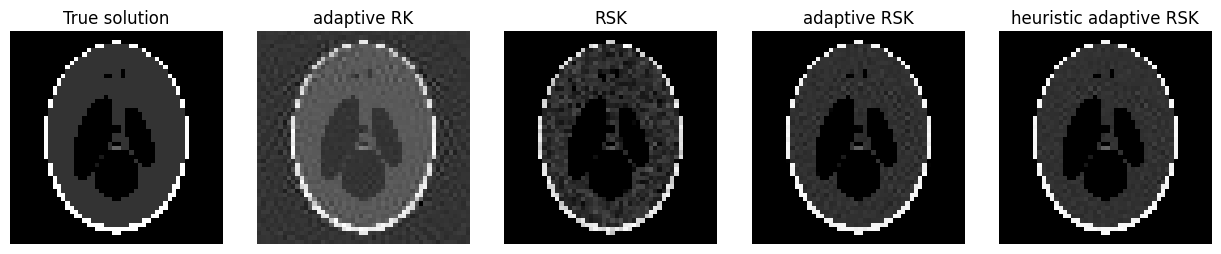

In [12]:
# plot reconstructions
Images = [x_true, x_ark, x_rsk, x_arsk, x_harsk]
New = int(np.sqrt(A.shape[0]))
Titles = ['True solution', 'adaptive RK', 'RSK', 'adaptive RSK', 'heuristic adaptive RSK']
fig, axes = plt.subplots(1, len(Images), figsize = (5*len(Images)/2, 1*len(Images)/2))

for (ax,i) in zip(axes.flat, range(len(Images))):
    ax.set_title(f'{Titles[i]}')
    ax.imshow(Images[i].reshape(N,N,order='F'), cmap='gray')
    ax.axis('off')
fig.tight_layout(pad = 1)
# plt.savefig('../figures/CT-reconstructions.pdf')
plt.show()

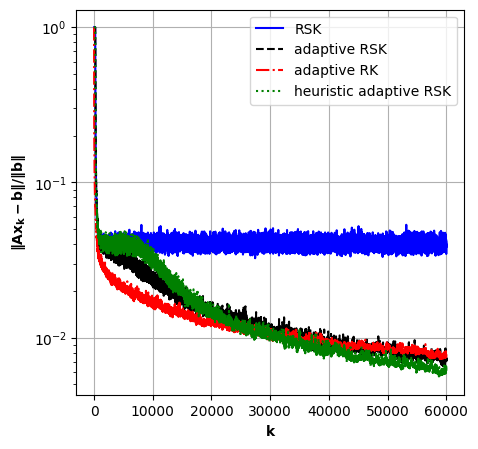

In [13]:
# plot residuals
plt.figure(figsize=(5,5))
plt.grid(True)
colors = ['blue', 'k', 'red', 'green']
linestyles = ['solid','dashed', '-.', 'dotted']

plt.semilogy(residuals_rsk, linestyle=linestyles[0], label=f'RSK', color=colors[0])
plt.semilogy(residuals_arsk, linestyle=linestyles[1], label=f'adaptive RSK', color=colors[1])
plt.semilogy(residuals_ark, linestyle=linestyles[2], label=f'adaptive RK', color=colors[2])
plt.semilogy(residuals_harsk, linestyle=linestyles[3], label=f'heuristic adaptive RSK', color=colors[3])

plt.xlabel(r'$\mathbf{k}$', fontsize=10)
plt.ylabel(r'$\mathbf{\|Ax_k - b\|/\|b\|}$', fontsize=10)
plt.legend()
# plt.savefig('../figures/CT-residuals.pdf')
plt.show()

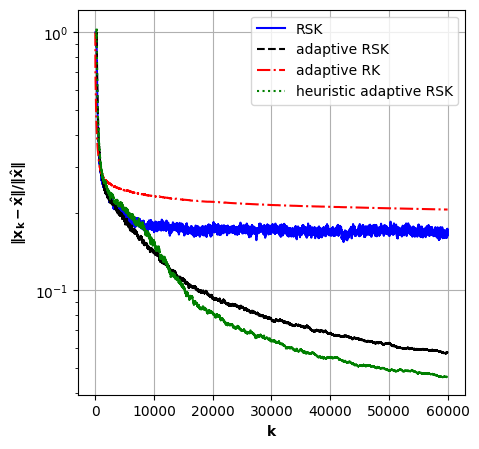

In [14]:
# plot distance to ground truth
plt.figure(figsize=(5,5))
plt.grid(True)
plt.semilogy(errors_rsk, linestyle=linestyles[0], label=f'RSK', color=colors[0])
plt.semilogy(errors_arsk, linestyle=linestyles[1], label=f'adaptive RSK', color=colors[1])
plt.semilogy(errors_ark, linestyle=linestyles[2], label=f'adaptive RK', color=colors[2])
plt.semilogy(errors_harsk, linestyle=linestyles[3], label=f'heuristic adaptive RSK', color=colors[3])

plt.xlabel(r'$\mathbf{k}$', fontsize=10)
plt.ylabel(r'$\mathbf{\|x_k - \hat x\|/\|\hat x\|}$', fontsize=10)
plt.legend()
# plt.savefig('../figures/CT-errors.pdf')
plt.show()